# Run if using GPU for the first time

In [ ]:
%pip uninstall jax jaxlib -y
%pip uninstall tensorflow -y
%pip uninstall tensorflow-gpu -y
%pip uninstall tensorflow-cpu -y
%pip uninstall -y torch
%pip uninstall -y torchvision
%pip uninstall -y jax-cuda12-plugin
%pip uninstall -y jax-cuda12-pjrt
%pip install "jax[cuda12]==0.6.2"
%pip install "tensorflow[and-cuda]"
%pip install -r ../requirements_gpu.txt

# Run if using CPU for the first time

In [ ]:
%pip uninstall jax jaxlib -y
%pip uninstall tensorflow -y
%pip uninstall tensorflow-gpu -y
%pip uninstall tensorflow-cpu -y
%pip uninstall -y jax-cuda12-plugin
%pip uninstall -y jax-cuda12-pjrt
%pip install jax==0.6.2
%pip install tensorflow-cpu==2.17.0
%pip install -r ../requirements.txt

# Import libraries

In [1]:
import functools
from functools import partial
import jax
import matplotlib.pyplot as plt
import numpy as np
from flax import nnx
from pathlib import Path
from typing import Optional, NamedTuple, Callable, Dict, List, Tuple, Union, Sequence
from jax import numpy as jnp
import math
import optax
import random
import os
import time
# from tqdm.notebook import tqdm
from tqdm import tqdm
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.data as tfd
from tensorflow.data import Dataset as tfds

SEED = 42
key = jax.random.key(SEED)
# Check available devices
print(device_lib.list_local_devices())
print("\n")
print(jax.devices())
print("\n")
print(jax.default_backend()) 

ERROR:2025-10-19 22:58:52,379:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 324, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 281, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load the CUDA libraries.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3569332528712538060
xla_global_id: -1
]


[CpuDevice(id=0)]


cpu


2025-10-19 22:58:56.033343: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Time-Series Simulator

## Kernels

In [2]:
@jax.jit
def constant_kernel(x, y, constant=1.0):
    return constant

@jax.jit
def white_noise_kernel(x, y, variance=1.0):
    return variance * (x == y)

@jax.jit
def polynomial_kernel(x, y, sigma=1.0, alpha=1.0):
    return (sigma + x.T @ y)**alpha

@jax.jit
def rbf_kernel(x, y, length_scale=1.0):
    squared_distance = jnp.sum((x - y) ** 2)
    return jnp.exp(-squared_distance / (2 * length_scale**2))

@jax.jit
def rational_quadratic_kernel(x, y, alpha=1.0, length_scale=1.0):
    squared_distance = jnp.sum((x - y) ** 2)
    return (1 + squared_distance / (2 * alpha)) ** (-alpha)

@jax.jit
def periodic_kernel(x, y, p=1.0):
    distance = jnp.linalg.norm(x - y)
    return jnp.exp(-2 * jnp.sin(jnp.pi * distance / p) ** 2)

### Gram Matrix generators

@jax.jit
def gram_constant(X, constant=1.0):
    """Computes the Gram matrix for the constant kernel."""
    n = X.shape[0]
    gram_matrix = jnp.full((n, n), constant)
    return jnp.squeeze(gram_matrix)

@jax.jit
def gram_white_noise(X, variance=1.0):
    """Computes the Gram matrix for the white noise kernel."""
    n = X.shape[0]
    gram_matrix = variance * jnp.eye(n)
    return jnp.squeeze(gram_matrix)

@jax.jit
def gram_polynomial(X, sigma=1.0, alpha=1.0):
    """Computes the Gram matrix for the linear kernel."""
    gram_matrix = (sigma + X @ X.T)**alpha
    return jnp.squeeze(gram_matrix)

@jax.jit
def gram_rbf(X, length_scale=1.0):
    """Computes the Gram matrix for the RBF kernel."""
    pairwise_sq_dists = jax.vmap(lambda x: jax.vmap(lambda y: jnp.sum((x - y) ** 2))(X))(X)
    gram_matrix = jnp.exp(-pairwise_sq_dists / (2 * length_scale**2))
    return jnp.squeeze(gram_matrix)

@jax.jit
def gram_rational_quadratic(X, alpha=1.0, length_scale=1.0):
    """Computes the Gram matrix for the rational quadratic kernel."""
    pairwise_sq_dists = jax.vmap(lambda x: jax.vmap(lambda y: jnp.sum((x - y) ** 2))(X))(X)
    gram_matrix = (1 + pairwise_sq_dists / (2 * alpha * length_scale**2)) ** (-alpha)
    return jnp.squeeze(gram_matrix)

@jax.jit
def gram_periodic(X, p=1.0):
    """Computes the Gram matrix for the periodic kernel."""
    pairwise_dists = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(X))(X)
    gram_matrix = jnp.exp(-2 * jnp.sin(jnp.pi * pairwise_dists / p) ** 2)
    return jnp.squeeze(gram_matrix)

# def gram_tophat(X, width=1.0):
#     """Computes the Gram matrix for the tophat kernel."""
#     pairwise_dists = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(X))(X)
#     gram_matrix = (pairwise_dists <= width).astype(jnp.float32)
#     return jnp.squeeze(gram_matrix)
# @functools.partial(jax.jit, static_argnames=["kernel"])
# def gram(kernel, X):
#     """
#     Computes the Gram (covariance) matrix using a given kernel function.

#     Parameters:
#         kernel (function): A function that takes two vectors and returns a scalar.
#         X (jax.numpy.ndarray): A matrix of shape (n, d), where n is the number of points and d is the dimension.

#     Returns:
#         jax.numpy.ndarray: The Gram matrix of shape (n, n).
#     """
#     if X.ndim == 1:
#         X = X[:, None]

#     assert X.ndim == 2

#     n = X.shape[0]

#     gram_matrix = jax.vmap(lambda i: jax.vmap(lambda j: kernel(X[i], X[j]))(jnp.arange(n)))(jnp.arange(n))
#     return jnp.squeeze(gram_matrix)

@functools.partial(jax.jit, static_argnames=["length"])
def compute_all_gram_matrices(length: int, X=None):
    """
    Computes the Gram matrices for all kernels in the KERNEL_BANK.

    Parameters:
    -----------
    X : jax.numpy.ndarray
        A matrix of shape (n, d), where n is the number of points and d is the dimension.

    Returns:
    --------
    List of jax.numpy.ndarray:
        A list containing the Gram matrices for each kernel.
    """
    if X is None:
        X = jnp.linspace(0, 1, length)[:, None]
        # X = (jnp.arange(length)[:, None]) / length

    # Compute Gram matrices using specialized functions
    gram_matrices = [
        gram_constant(X, constant=1.0),
        gram_white_noise(X, variance=0.1),
        gram_white_noise(X, variance=1.0),
        gram_polynomial(X, sigma=0.0, alpha=1.0),
        gram_polynomial(X, sigma=1.0, alpha=1.0),
        gram_polynomial(X, sigma=10.0, alpha=1.0),
        gram_polynomial(X, sigma=0.0, alpha=2.0),
        gram_polynomial(X, sigma=1.0, alpha=2.0),
        gram_polynomial(X, sigma=10.0, alpha=2.0),
        gram_polynomial(X, sigma=0.0, alpha=3.0),
        gram_polynomial(X, sigma=1.0, alpha=3.0),
        gram_polynomial(X, sigma=10.0, alpha=3.0),
        gram_rbf(X, length_scale=0.01),
        gram_rbf(X, length_scale=0.1),
        gram_rbf(X, length_scale=1.0),
        gram_rbf(X, length_scale=10.0),
        gram_rational_quadratic(X, alpha=0.01),
        gram_rational_quadratic(X, alpha=0.1),
        gram_rational_quadratic(X, alpha=1.0),
        gram_rational_quadratic(X, alpha=10.0),
        gram_periodic(X, p=24/length),
        gram_periodic(X, p=48/length),
        gram_periodic(X, p=96/length),
        gram_periodic(X, p=24*7/length),
        gram_periodic(X, p=48*7/length),
        gram_periodic(X, p=96*7/length),
        gram_periodic(X, p=7/length),
        gram_periodic(X, p=14/length),
        gram_periodic(X, p=30/length),
        gram_periodic(X, p=60/length),
        gram_periodic(X, p=365/length),
        gram_periodic(X, p=365*2/length),
        gram_periodic(X, p=4/length),
        gram_periodic(X, p=26/length),
        gram_periodic(X, p=52/length),
        gram_periodic(X, p=4/length),
        gram_periodic(X, p=6/length),
        gram_periodic(X, p=12/length),
        gram_periodic(X, p=4/length),
        gram_periodic(X, p=4*10/length),
        gram_periodic(X, p=10/length)
    ]

    return jnp.array(gram_matrices)

@jax.jit
def random_cov_convolution(key: jax.Array, cov1: jax.Array, cov2: jax.Array):
    """
    Applies a random binary operator (+ or *) with equal probability
    on kernels ``a`` and ``b``.

    Parameters
    ----------
    kernel1: A GP kernel.
    kernel2: A GP kernel.

    Returns
    -------
        The composite kernel `kernel1 + kernel2` or `kernel1 * kernel2`.
    """
    convolutions = jnp.array([cov1 + cov2, cov1 * cov2])


    key, subkey = jax.random.split(key)
    sampled_cov_conv = jax.random.choice(subkey, convolutions)

    return sampled_cov_conv, key

@jax.jit
def generate_convolution(key: jax.Array, cov_list: jax.Array):

    # Combine the sampled kernels using random binary operators
    def combine_covs(carry, cov):
        key, cov_conv = carry
        next_cov, next_key = random_cov_convolution(key, cov, cov_conv)
        next_carry = (next_key, next_cov)
        return next_carry, next_cov

    init_carry = (key, cov_list[0])
    
    
    (key, cov_conv), _ = jax.lax.scan(combine_covs, init = init_carry, xs = cov_list)
    
    return cov_conv, key


## Sampling Methods

In [3]:
@functools.partial(nnx.jit, static_argnames=["num_rows", "num_cols", "num_variate_kernels", "num_time_kernels"])
def generate_matrix_normal(key: jax.Array, num_rows: int, num_cols: int, num_time_kernels: int, num_variate_kernels: int, eps: float = 1e-6) -> Tuple[jnp.ndarray, jax.Array]:
    """Generate a synthetic time series from KernelSynth.

    Parameters
    ----------
    num_kernels, optional
        The number of base kernels to use for each time series, by default 5

    Returns
    -------
        A time series generated by KernelSynth.
    """
    length = num_rows * num_cols

    
    
    U_cov_matrices = compute_all_gram_matrices(num_rows)
    V_cov_matrices = compute_all_gram_matrices(num_cols)
    
    
    # Generate a gramm matrices
    key, subkey1, subkey2 = jax.random.split(key, num=3)
    
    U_cov_list = jax.random.choice(subkey1, U_cov_matrices, shape=(num_time_kernels,), replace=True)
    V_cov_list = jax.random.choice(subkey2, V_cov_matrices, shape=(num_variate_kernels,), replace=True)
    # print("U_cov_list:", U_cov_list)
    # print("V_cov_list:", V_cov_list)
    
    # Convolve the gramm matrices randomly
    key, subkey3, subkey4 = jax.random.split(key, num=3)
    U, _ = generate_convolution(subkey3, U_cov_list)
    V, _ = generate_convolution(subkey4, V_cov_list)

    U = U + eps*jnp.eye(num_rows)
    V = V + eps*jnp.eye(num_cols)

    A = jax.numpy.linalg.cholesky(U, upper=False)
    B = jax.numpy.linalg.cholesky(V, upper=True)
    
    # Generate matrix normal
    key, subkey = jax.random.split(key, num=2)
    vector_standard_normal = jax.random.normal(subkey, shape=(length,))
    matrix_standard_normal = vector_standard_normal.reshape((num_rows, num_cols))

    matrix_normal = A @ matrix_standard_normal @ B
    
    
    return matrix_normal, key

@functools.partial(nnx.jit, static_argnames=["num_samples", "num_rows", "num_cols", "num_variate_kernels", "num_time_kernels"])
def generate_matrix_normal_dataset(
    key: jax.Array,
    num_samples: int,
    num_rows: int,
    num_cols: int,
    num_time_kernels: int,
    num_variate_kernels: int,
    eps: float = 1e-3
    ) -> Tuple[jnp.ndarray, jax.Array]:
    """
    Generate a dataset of synthetic time series using KernelSynth.

    Parameters
    ----------
    key: jax.Array
        Random key for reproducibility.
    num_samples : int
        The number of time series to generate.
    length : int
        The length of each time series.
    num_kernels : int
        The number of base kernels to use for each time series.
    
    Returns
    -------
    Tuple[jnp.ndarray, jnp.ndarray]
        A tuple containing the generated time series and their corresponding keys.
    """
    
    generate_time_series_vmapped = nnx.vmap(generate_matrix_normal, in_axes = (0, None, None, None, None, None), out_axes = 0)
    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, num=num_samples)
    matrix_normal_batch, _ = generate_time_series_vmapped(subkeys, num_rows, num_cols, num_time_kernels, num_variate_kernels, eps=eps)

    return matrix_normal_batch, key

In [ ]:
start_time = time.time()
ts_data, key = jax.block_until_ready(generate_matrix_normal_dataset(key, 5, 5000, 5, 5, 5))
end_time = time.time()
print(f"Time taken to generate a dataset of 32 time-series sample: {end_time - start_time:.4f} seconds")
print(f"Output shape: {ts_data.shape}")

print("ts_data has nans:", jnp.any(jnp.isnan(ts_data)))

Time taken to generate a dataset of 32 time-series sample: 15.8088 seconds
Output shape: (5, 5000, 5)
ts_data has nans: True


## Plot example of generated time-series data

In [86]:
def plot_time_series_grid(ts_data):
    num_samples, length, num_variates = ts_data.shape

    fig, axes = plt.subplots(num_samples, num_variates, figsize=(30, 3*num_samples), constrained_layout=True)

    
    if num_samples == 1 and num_variates == 1:
        axes = np.array([[axes]])
    elif num_samples == 1:
        axes = np.expand_dims(axes, axis=0)
    elif num_variates == 1:
        axes = np.expand_dims(axes, axis=1)
        
    for i in range(num_samples):
        for j in range(num_variates):
            axes[i][j].plot(ts_data[i,:,j], linewidth=0.5)
            axes[i][j].set_title(f"Series {i}, Variate {j}", fontsize=8)
            # ax.set_xticks([])
            # ax.set_yticks([])
    

    plt.show()


Dimensions of generated dataset (10, 2500, 10)


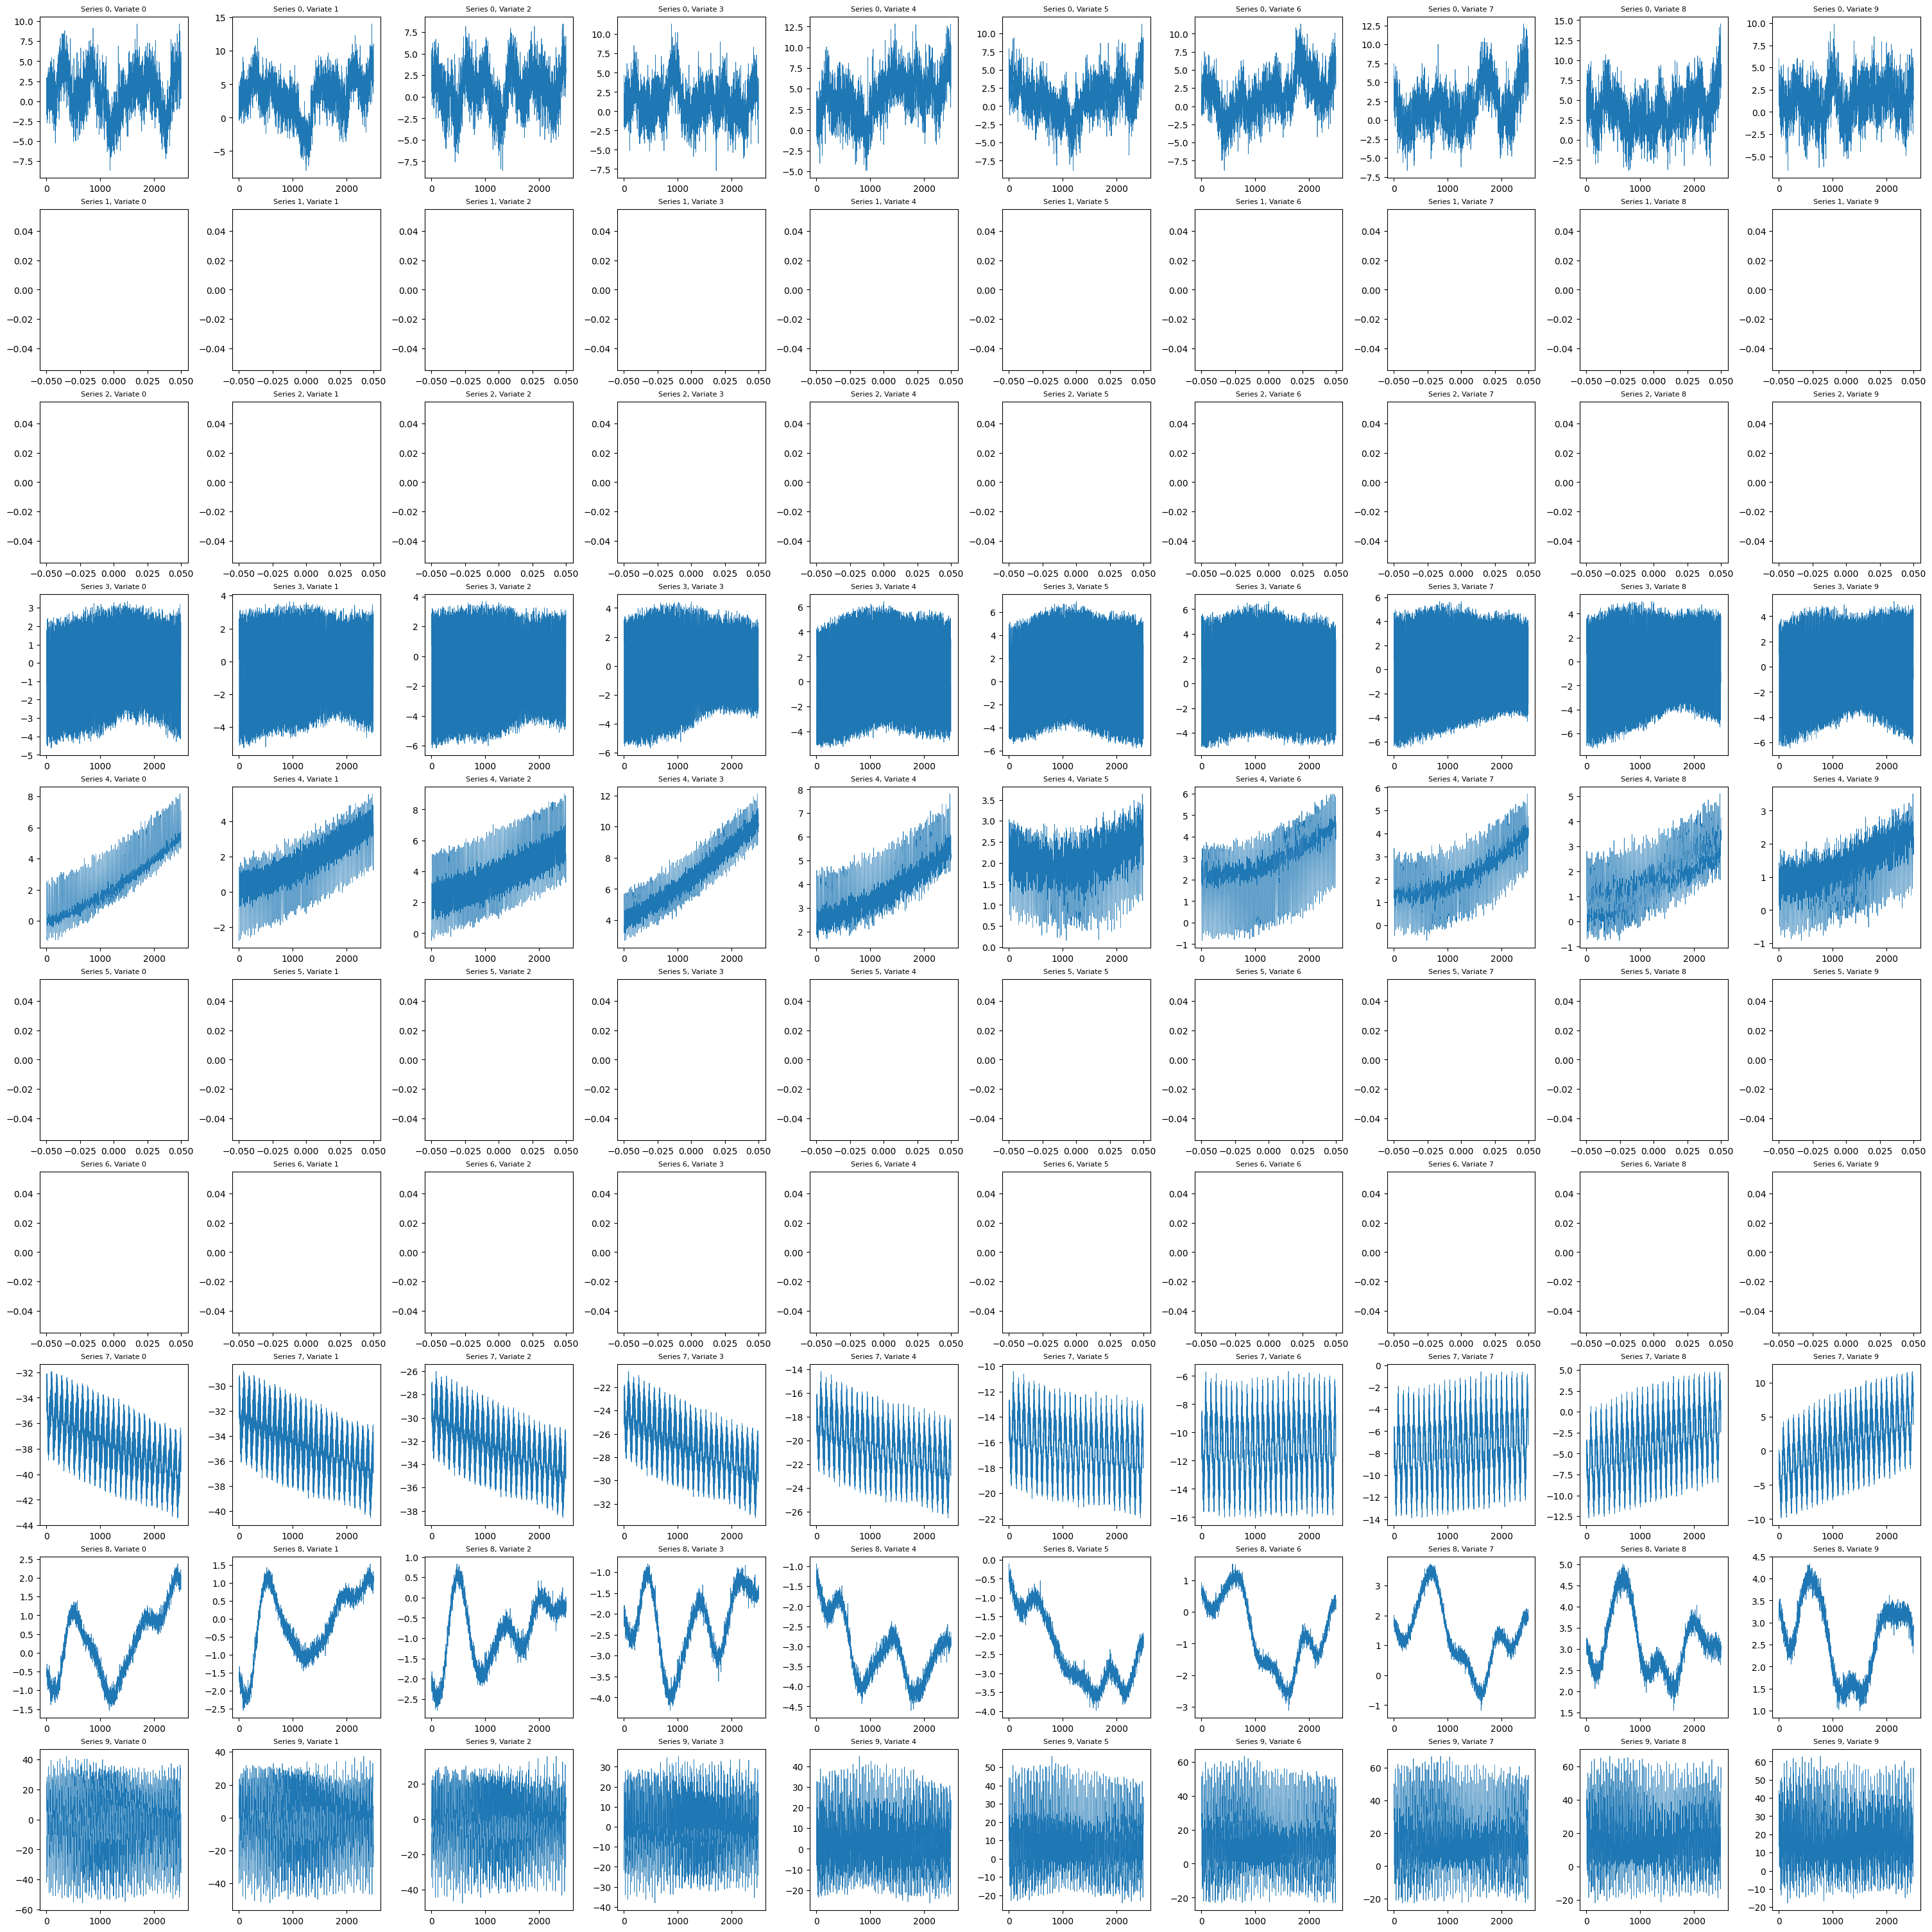

In [92]:
# Define parameters
num_samples = 10  # Total number of time series samples
length = 2500  # Define the length of each time series
num_variates = 10  # Number of variates in each time series
num_time_kernels = 4 # Maximum number of time kernels
num_variate_kernels = 4 # Maximum number of base kernels per variate
eps = 1e-2
# Generate the batch
ts_data, key = generate_matrix_normal_dataset(key, num_samples, length, num_variates, num_time_kernels, num_variate_kernels, eps=eps)

print("Dimensions of generated dataset", ts_data.shape) # = (num_samples, length)

plot_time_series_grid(ts_data)

## Data Generation Pipeline

In [79]:
def create_data_batch(key: jax.Array,
                          batch_size:int,
                          length: int,
                          num_variates: int,
                          num_time_kernels: int,
                          num_variate_kernels: int,
                          eps:float
                          ):
    
    """Create a training batch of data."""
    
    
    ts_data, key = generate_matrix_normal_dataset(key, batch_size, length, num_variates, num_time_kernels, num_variate_kernels, eps)
    
    while jnp.any(jnp.isnan(ts_data)):
        ts_data, key = generate_matrix_normal_dataset(key, batch_size, length, num_variates, num_time_kernels, num_variate_kernels, eps)
        
    if batch_size == 1:
        ts_data = jnp.squeeze(ts_data, axis=0)
    

    return ts_data, key

Time taken to generate a batch of size 2 : 2.62 seconds


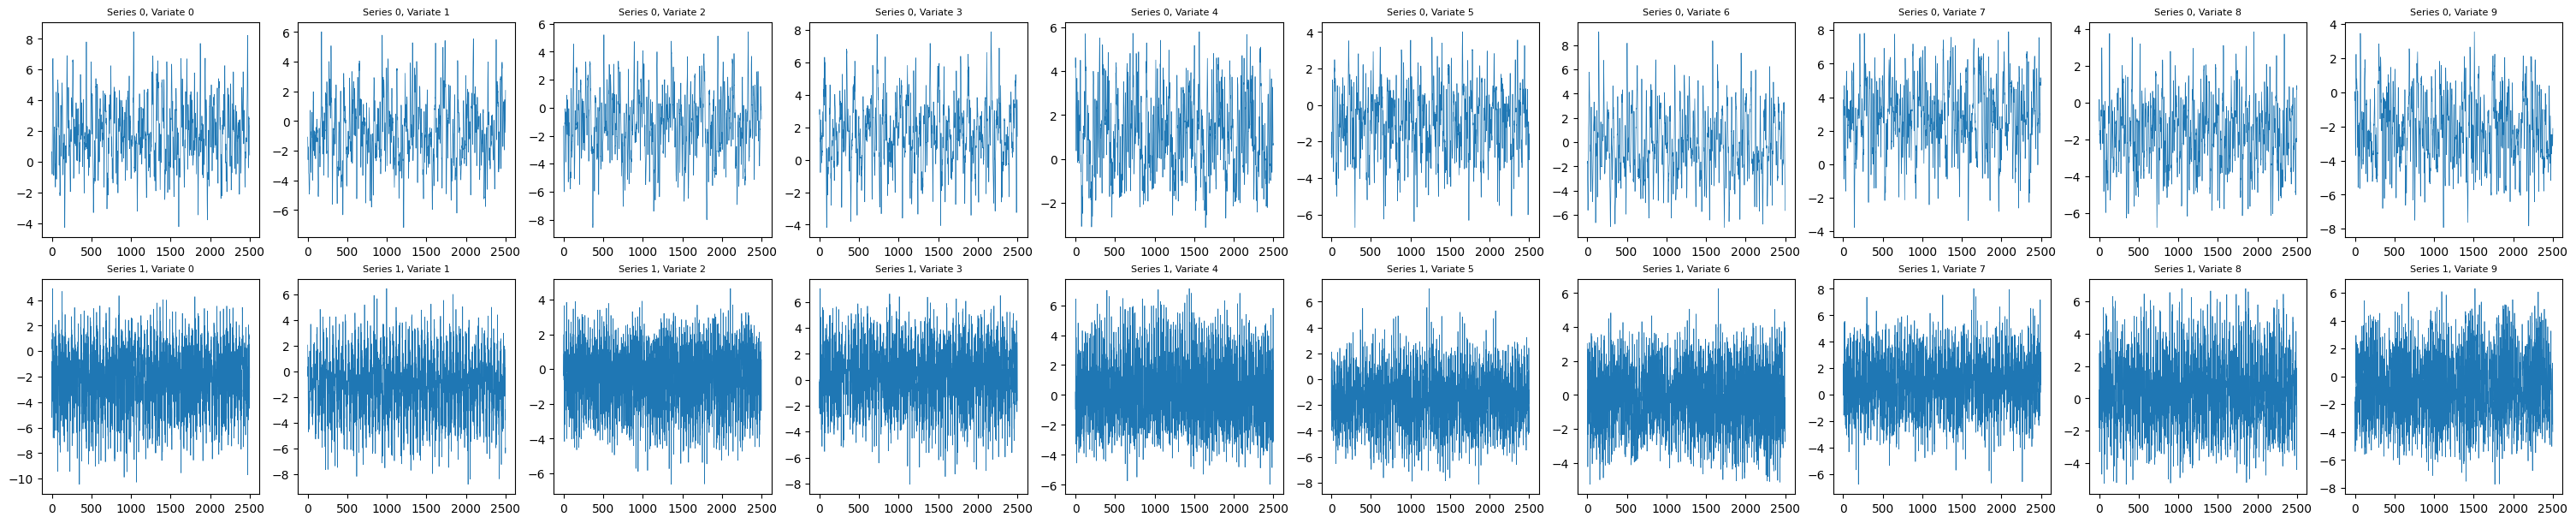

In [91]:
batch_size = 2  # Total number of time series samples
length = 2500  # Define the length of each time series
num_variates = 10  # Number of variates in each time series
num_time_kernels = 4  # Maximum number of base kernels per time series
num_variate_kernels = 3
eps = 1e-2

start_time = time.time()
ts_synth_dataset, key = jax.block_until_ready(
    create_data_batch(key, 
                    batch_size=batch_size,
                    length=length, 
                    num_variates=num_variates,
                    num_time_kernels=num_time_kernels,
                    num_variate_kernels=num_variate_kernels,
                    eps=eps
                    )
)
end_time = time.time()
print(f"Time taken to generate a batch of size {batch_size} : {end_time - start_time:.2f} seconds")

jax.tree_util.tree_map(lambda x:x.shape, ts_synth_dataset)

plot_time_series_grid(ts_synth_dataset)

In [ ]:
key = jax.random.key(SEED)

batch_size = 1  # Total number of time series samples
length = 2500  # Define the length of each time series
num_variates = 10  # Number of variates in each time series
max_num_time_kernels = 4  # Maximum number of base kernels per time series
max_num_variate_kernels = 3
eps = 1e-2

num_total_samples =  1000000  # Total number of time series samples
# num_total_samples = 1000000  # Total number of time series samples
num_iterations = num_total_samples // batch_size  


# Define the generator function

def data_generator(key):
    
    for iter in tqdm(range(num_iterations)):
        # print(f"Iteration {iter + 1}/{num_iterations}")
        key, subkey1, subkey2 = jax.random.split(key, num = 3)

        num_time_kernels = jax.random.randint(subkey1, (1,), minval=1, maxval=max_num_time_kernels+1).item()
        num_variate_kernels = jax.random.randint(subkey2, (1,), minval=1, maxval=max_num_variate_kernels+1).item()
        
        

        # Generate one batch of 128 time series
        ts_batch, key = create_data_batch(key, 
                    batch_size=batch_size,
                    length=length, 
                    num_variates=num_variates,
                    num_time_kernels=num_time_kernels,
                    num_variate_kernels=num_variate_kernels,
                    eps = eps)
            
        # Convert JAX array to NumPy for TensorFlow compatibility.
        ts_batch_np = jax.tree_util.tree_map(lambda x: np.asarray(x), ts_batch)
        
        # Yield each batch one-by-one.
        yield ts_batch_np

if batch_size == 1:
    # Define the expected output signature.
    output_signature = tf.TensorSpec(shape=(length, num_variates), dtype=tf.float32)
else:
    # Define the expected output signature.
    output_signature = tf.TensorSpec(shape=(batch_size, length, num_variates), dtype=tf.float32)
    

# Create the TensorFlow dataset from the generator.
dataset = tf.data.Dataset.from_generator(
    functools.partial(data_generator, key=key),
    output_signature = output_signature
)

# (Optional) You can add prefetching or further processing here.
dataset = dataset.prefetch(tf.data.AUTOTUNE)


# Create filepaths for saving the dataset, file names are generated based on the current time.
current_time = time.strftime("%Y_%m_%d_%H:%M:%S")
file_path = f"../data/tempo_v1_largest_{current_time}"


# # Save the dataset to disk. This will create a directory named "kernel_synth_dataset".
dataset.save(file_path)


# print("Dataset generation and saving initiated.")

I0000 00:00:1760742683.973789   11610 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17988 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:04:00.0, compute capability: 9.0
100%|██████████| 1000000/1000000 [57:48<00:00, 288.28it/s]
